# Step-by-step sampling with a 1D diffusion model

Goal:
- Define a 1D target distribution p(x) (mixture of Gaussians)
- Define a forward noising process x0 -> xt
- Train a neural net to predict the noise added at step t
- Sample by iteratively denoising from xT ~ N(0,1) back to x0

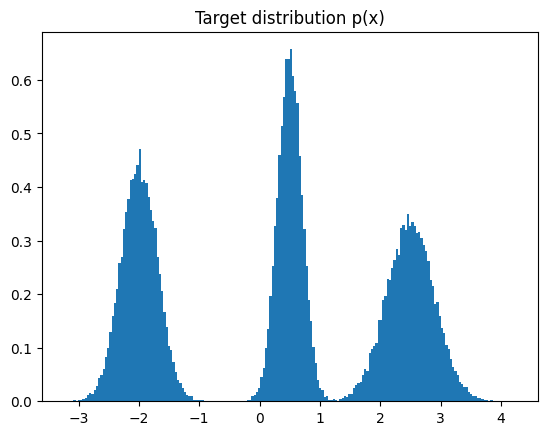

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(0)
np.random.seed(0)
device = "cuda" if torch.cuda.is_available() else "cpu"

# Target distribution: mixture of Gaussians
def sample_target(n, device=device):
    comp = torch.randint(0, 3, (n,), device=device)
    means = torch.tensor([-2.0, 0.5, 2.5], device=device)
    stds  = torch.tensor([0.3, 0.2, 0.4], device=device)
    x0 = torch.randn(n, device=device) * stds[comp] + means[comp]
    return x0.view(-1, 1)

# quick look
x_ref = sample_target(50_000).detach().cpu().numpy()
plt.hist(x_ref, bins=200, density=True)
plt.title("Target distribution p(x)")
plt.show()

In [2]:
T = 200  # diffusion steps (keep modest for CPU)
beta_start, beta_end = 1e-4, 2e-2

betas = torch.linspace(beta_start, beta_end, T, device=device)          # [T]
alphas = 1.0 - betas                                                    # [T]
alpha_bar = torch.cumprod(alphas, dim=0)                                # [T]

# helpers for indexing by t (batch)
def gather(v, t, shape):
    # v: [T], t: [B] int64
    out = v.gather(0, t)
    return out.view(shape)

In [3]:
def q_sample(x0, t):
    """
    x_t = sqrt(alpha_bar_t) * x0 + sqrt(1 - alpha_bar_t) * eps
    """
    B = x0.shape[0]
    eps = torch.randn_like(x0)
    ab = gather(alpha_bar, t, (B, 1))
    xt = torch.sqrt(ab) * x0 + torch.sqrt(1.0 - ab) * eps
    return xt, eps

In [4]:
class Denoise1D(nn.Module):
    def __init__(self, hidden=128):
        super().__init__()
        self.t_embed = nn.Sequential(
            nn.Linear(1, hidden),
            nn.SiLU(),
            nn.Linear(hidden, hidden),
        )
        self.net = nn.Sequential(
            nn.Linear(1 + hidden, hidden),
            nn.SiLU(),
            nn.Linear(hidden, hidden),
            nn.SiLU(),
            nn.Linear(hidden, 1),
        )

    def forward(self, xt, t):
        # t in [0..T-1], normalize to [0,1]
        t_norm = (t.float() / (T - 1)).view(-1, 1)
        te = self.t_embed(t_norm)
        x = torch.cat([xt, te], dim=1)
        return self.net(x)

model = Denoise1D(hidden=128).to(device)

In [5]:
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)

batch_size = 4096
steps = 4000  # training iterations

model.train()
for it in range(steps + 1):
    x0 = sample_target(batch_size)
    t = torch.randint(0, T, (batch_size,), device=device)

    xt, eps = q_sample(x0, t)
    eps_pred = model(xt, t)

    loss = F.mse_loss(eps_pred, eps)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if it % 400 == 0:
        print(f"iter {it:4d} | loss = {loss.item():.6f}")

iter    0 | loss = 0.994460
iter  400 | loss = 0.683027
iter  800 | loss = 0.688932
iter 1200 | loss = 0.618893
iter 1600 | loss = 0.607037
iter 2000 | loss = 0.610950
iter 2400 | loss = 0.647518
iter 2800 | loss = 0.643606
iter 3200 | loss = 0.611506
iter 3600 | loss = 0.598899
iter 4000 | loss = 0.609474


In [19]:
@torch.no_grad()
def p_sample_loop(model, n_samples=50_000):
    model.eval()
    x = torch.randn(n_samples, 1, device=device)  # x_T ~ N(0,1)

    for ti in reversed(range(T)):
        t = torch.full((n_samples,), ti, device=device, dtype=torch.long)

        beta_t = betas[ti]
        alpha_t = alphas[ti]
        ab_t = alpha_bar[ti]

        eps_pred = model(x, t)

        # mean of p(x_{t-1} | x_t)
        coef = beta_t / torch.sqrt(1.0 - ab_t)
        mean = (1.0 / torch.sqrt(alpha_t)) * (x - coef * eps_pred)

        if ti > 0:
            z = torch.randn_like(x)
            sigma = torch.sqrt(beta_t)  # simple variance choice
            x = mean + sigma * z
        else:
            x = mean  # final step: no noise

    return x

x_gen = p_sample_loop(model, n_samples=50_000).cpu().numpy()

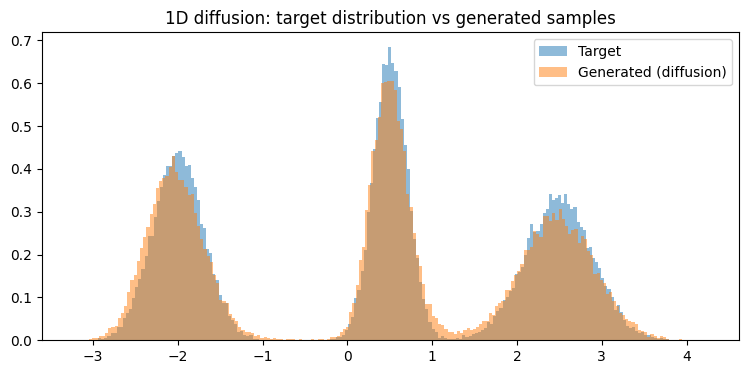

In [20]:
x_ref = sample_target(50_000, device=device).cpu().numpy()

plt.figure(figsize=(9,4))
plt.hist(x_ref, bins=200, density=True, alpha=0.5, label="Target")
plt.hist(x_gen, bins=200, density=True, alpha=0.5, label="Generated (diffusion)")
plt.legend()
plt.title("1D diffusion: target distribution vs generated samples")
plt.savefig("1_sampling_final.png")
plt.show()

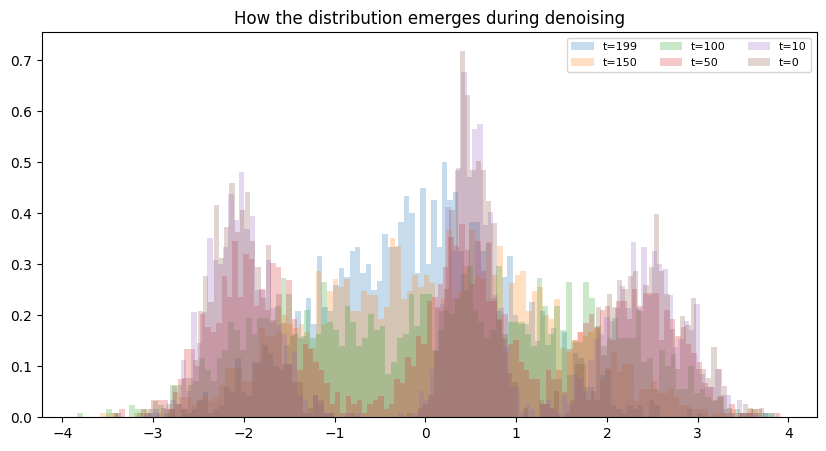

In [10]:
@torch.no_grad()
def sample_with_snapshots(model, n=2000, snapshot_steps=(199,150,100,50,10,0)):
    model.eval()
    x = torch.randn(n, 1, device=device)
    snaps = {}

    for ti in reversed(range(T)):
        if ti in snapshot_steps:
            snaps[ti] = x.detach().cpu().numpy()

        t = torch.full((n,), ti, device=device, dtype=torch.long)
        beta_t = betas[ti]
        alpha_t = alphas[ti]
        ab_t = alpha_bar[ti]

        eps_pred = model(x, t)
        coef = beta_t / torch.sqrt(1.0 - ab_t)
        mean = (1.0 / torch.sqrt(alpha_t)) * (x - coef * eps_pred)

        if ti > 0:
            x = mean + torch.sqrt(beta_t) * torch.randn_like(x)
        else:
            x = mean

    snaps[0] = x.detach().cpu().numpy()
    return snaps

snaps = sample_with_snapshots(model)

plt.figure(figsize=(10,5))
for ti in sorted(snaps.keys(), reverse=True):
    plt.hist(snaps[ti], bins=120, density=True, alpha=0.25, label=f"t={ti}")
plt.title("How the distribution emerges during denoising")
plt.legend(ncol=3, fontsize=8)
plt.savefig("2_diffusion_steps.png")
plt.show()